In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from os.path import join
from tqdm import tqdm
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [42]:
np.random.seed(42)

---

In [2]:
SITES = ['prudhoe_12', 'prudhoe_15', 'prudhoe_22']
DIR = '/scratch/richardso21/20-21_BGSUB/FgSegNet_O_neg/'

In [15]:
class DataSite:
    def __init__(self, output_path):
        print(output_path)
        self.output_path = output_path
        self.PDIR = join(output_path, 'pos')
        self.NDIR = join(output_path, 'neg')
        
        pmaxesl = []
        ptotalsl = []
        nmaxesl = []
        ntotalsl = []
        
        for fn in tqdm(os.listdir(self.PDIR)):
            full_fn = join(self.PDIR, fn)
            npy = np.load(full_fn)
            pmaxesl.append(np.max(npy))
            ptotalsl.append(np.sum(npy))

        for fn in tqdm(os.listdir(self.NDIR)):
            full_fn = join(self.NDIR, fn)
            npy = np.load(full_fn)
            nmaxesl.append(np.max(npy))
            ntotalsl.append(np.sum(npy))
        
        self.pmaxes = np.array(pmaxesl)
        self.ptotals = np.array(ptotalsl)
        self.nmaxes = np.array(nmaxesl)
        self.ntotals = np.array(ntotalsl)
        
    def maxProb(self, title="Histogram comparison of Max probabilities", save=""):
        plt.hist(self.pmaxes, alpha=0.75, label='positive')
        plt.hist(self.nmaxes, alpha=0.75, label='negative')
        
        plt.title(title)
        plt.legend()
        
        if not save=="":
            plt.savefig(save)
        
    def sumProb(self, zscore=0, rg=(0,250), title="Comparison of summed pixel probabilities", save=""):
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=80, sharey=True)
#         if zBool:
#             ptotalsz = np.delete(self.ptotals, np.where(np.abs(stats.zscore(self.ptotals) > 2)))
#             ntotalsz = np.delete(self.ntotals, np.where(np.abs(stats.zscore(self.ntotals) > 2)))
#         else:
#             ptotalsz = self.ptotals
#             ntotalsz = self.ntotals
#         ax1.hist(ptotalsz, range=rg, alpha=0.75)
#         ax1.title.set_text("Positive Labels")
#         ax2.hist(ntotalsz, range=rg, alpha=0.75)
#         ax2.title.set_text("Negative Labels")
#         fig.suptitle(title)
        if zscore > 0:
            ptotalsz = np.delete(self.ptotals, np.where(np.abs(stats.zscore(self.ptotals) > zscore)))
            ntotalsz = np.delete(self.ntotals, np.where(np.abs(stats.zscore(self.ntotals) > zscore)))
        else:
            ptotalsz = self.ptotals
            ntotalsz = self.ntotals
        plt.hist(ptotalsz, range=rg, alpha=0.75, label='positive')
        plt.hist(ntotalsz, range=rg, alpha=0.75, label='negative')
        
        plt.title(title)
        plt.legend()
        
        if not save=="":
            plt.savefig(save)

In [16]:
p12 = DataSite(join(DIR, SITES[0]))

  6%|▌         | 54/961 [00:00<00:01, 535.31it/s]

/scratch/richardso21/20-21_BGSUB/FgSegNet_O_neg/prudhoe_12


100%|██████████| 1871/1871 [00:56<00:00, 33.19it/s]


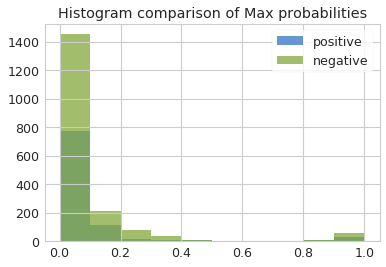

In [17]:
p12.maxProb()

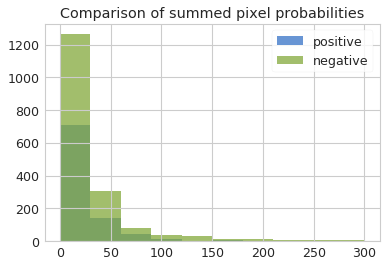

In [37]:
p12.sumProb(zscore=0, rg=(0, 300))

In [36]:
p15 = DataSite(join(DIR, SITES[1]))

  0%|          | 2/518 [00:00<00:31, 16.38it/s]

/scratch/richardso21/20-21_BGSUB/FgSegNet_O_neg/prudhoe_15


100%|██████████| 1032/1032 [00:59<00:00, 17.30it/s]


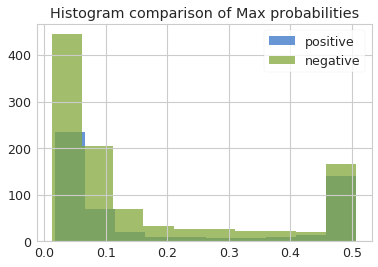

In [38]:
p15.maxProb()

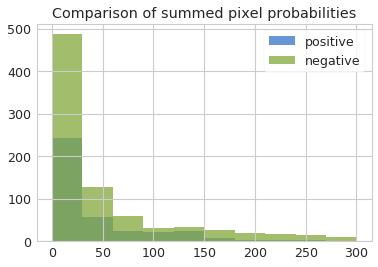

In [40]:
p15.sumProb(zscore=0, rg=(0, 300))

---

In [57]:
class ThresholdSite(DataSite):
    def __init__(self, output_path):
        super().__init__(output_path)
        self.bestThr = 0
        self.trainSp = None
        self.testSp = None
        
    def dataSplits(self):
        X = np.concatenate((self.ptotals, self.ntotals))
        y = np.concatenate((np.ones(len(self.ptotals)), np.zeros(len(self.ntotals))))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)
        
        self.trainSp = X_train, y_train
#         self.valSp = X_val, y_val
        self.testSp = X_test, y_test
        
    def findThr(self, L=None, H=None):
        if H is None:
            H = max(self.trainSp[0])
        if L is None:
            L = min(self.trainSp[0])
            
        if self.trainSp is None:
            print('Running dataSplits first!')
            self.dataSplits()
        
        if H - L < 50:
            print('lower or higher limit outside of valid scope!')
            return
        
        accs = {}
#         check accuracy of thresholding pixel sums in 50 increments between the lower/upper limits
        for i in np.linspace(L, H, 50):
            print(f'Checking Threshold Accuracy of: {i}')
            thr_arr = self.trainSp[0] > i
            res = thr_arr == self.trainSp[1]
#             take average accuracy
            accs[i] = sum(res) / len(res)
            del thr_arr
        print(accs)
        self.bestThr = max(accs, key=accs.get)
        print(f'Finding best threshold: {self.bestThr}')


In [59]:
p12_thr = ThresholdSite(join(DIR, SITES[0]))

  0%|          | 3/961 [00:00<00:42, 22.42it/s]

/scratch/richardso21/20-21_BGSUB/FgSegNet_O_neg/prudhoe_12


100%|██████████| 1871/1871 [01:07<00:00, 27.54it/s]


In [60]:
p12_thr.dataSplits()

In [61]:
p12_thr.findThr()

Checking Threshold Accuracy of: 0.14927828311920166
Checking Threshold Accuracy of: 2403.2288210732595
Checking Threshold Accuracy of: 4806.3083638634
Checking Threshold Accuracy of: 7209.38790665354
Checking Threshold Accuracy of: 9612.46744944368
Checking Threshold Accuracy of: 12015.54699223382
Checking Threshold Accuracy of: 14418.626535023961
Checking Threshold Accuracy of: 16821.706077814102
Checking Threshold Accuracy of: 19224.78562060424
Checking Threshold Accuracy of: 21627.86516339438
Checking Threshold Accuracy of: 24030.94470618452
Checking Threshold Accuracy of: 26434.024248974663
Checking Threshold Accuracy of: 28837.103791764803
Checking Threshold Accuracy of: 31240.183334554942
Checking Threshold Accuracy of: 33643.262877345085
Checking Threshold Accuracy of: 36046.342420135225
Checking Threshold Accuracy of: 38449.421962925364
Checking Threshold Accuracy of: 40852.5015057155
Checking Threshold Accuracy of: 43255.58104850564
Checking Threshold Accuracy of: 45658.660591

In [62]:
p12_thr.findThr(26434, 28837)

Checking Threshold Accuracy of: 26434.0
Checking Threshold Accuracy of: 26483.04081632653
Checking Threshold Accuracy of: 26532.081632653062
Checking Threshold Accuracy of: 26581.122448979593
Checking Threshold Accuracy of: 26630.163265306124
Checking Threshold Accuracy of: 26679.20408163265
Checking Threshold Accuracy of: 26728.244897959183
Checking Threshold Accuracy of: 26777.285714285714
Checking Threshold Accuracy of: 26826.326530612245
Checking Threshold Accuracy of: 26875.367346938776
Checking Threshold Accuracy of: 26924.408163265307
Checking Threshold Accuracy of: 26973.448979591838
Checking Threshold Accuracy of: 27022.48979591837
Checking Threshold Accuracy of: 27071.530612244896
Checking Threshold Accuracy of: 27120.571428571428
Checking Threshold Accuracy of: 27169.61224489796
Checking Threshold Accuracy of: 27218.65306122449
Checking Threshold Accuracy of: 27267.69387755102
Checking Threshold Accuracy of: 27316.73469387755
Checking Threshold Accuracy of: 27365.77551020408

In [63]:
p15_thr = ThresholdSite(join(DIR, SITES[1]))

  0%|          | 2/518 [00:00<00:31, 16.61it/s]

/scratch/richardso21/20-21_BGSUB/FgSegNet_O_neg/prudhoe_15


100%|██████████| 1032/1032 [01:02<00:00, 16.52it/s]


In [65]:
p15_thr.dataSplits()

In [66]:
p15_thr.findThr()

Checking Threshold Accuracy of: 0.7730931043624878
Checking Threshold Accuracy of: 4076.2471116124366
Checking Threshold Accuracy of: 8151.721130120511
Checking Threshold Accuracy of: 12227.195148628585
Checking Threshold Accuracy of: 16302.669167136659
Checking Threshold Accuracy of: 20378.143185644734
Checking Threshold Accuracy of: 24453.617204152808
Checking Threshold Accuracy of: 28529.09122266088
Checking Threshold Accuracy of: 32604.565241168955
Checking Threshold Accuracy of: 36680.03925967703
Checking Threshold Accuracy of: 40755.513278185106
Checking Threshold Accuracy of: 44830.98729669318
Checking Threshold Accuracy of: 48906.46131520125
Checking Threshold Accuracy of: 52981.93533370933
Checking Threshold Accuracy of: 57057.4093522174
Checking Threshold Accuracy of: 61132.883370725474
Checking Threshold Accuracy of: 65208.35738923355
Checking Threshold Accuracy of: 69283.83140774163
Checking Threshold Accuracy of: 73359.3054262497
Checking Threshold Accuracy of: 77434.77944